2023-12-12 Meeting

- Use click rate everywhere
- Implement Causal Model: + Reading
    - We divide every click rate by the article mean and the plug it in regression
- Make Regplot https://seaborn.pydata.org/generated/seaborn.regplot.html - should expect a clear upwards trend
- Taking the predictions of the correlational model and compare the top and least rated

In [1]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.linear_model import RidgeCV, LogisticRegression, LinearRegression
from torch.utils.data import DataLoader, TensorDataset
import csv
import torch 
import pickle
import random
from sklearn.metrics import accuracy_score
from scipy.stats import spearmanr
import math
import shap
import langid


In [2]:
#cpu/gpu
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

No GPU available, using the CPU instead.


In [3]:
#Load data
df = pd.read_csv("upworthy-archive-confirmatory-packages-03.12.2020.csv", low_memory=False)
#adding index
df.reset_index(inplace=True,names=["embedding_id"])

#remove rows without eyecatcher_id (about 100)
has_eyecatcher_id = df['eyecatcher_id'].notna()
df = df.loc[has_eyecatcher_id]
#Create a new column for clickrate
df["clickrate"] = round((df["clicks"]/ df["impressions"]), ndigits=10)

#filter data based on same clickability_id and eyecatcher_id
df['headline_count'] = df.groupby(['clickability_test_id', 'eyecatcher_id']).headline.transform('count')
df.columns
# filter for all headlines with at least 2 pairs. 
df = df.loc[df['headline_count']>=2, ['clickability_test_id', 'excerpt', 'headline', 'lede', 'eyecatcher_id', 'clicks', 'headline_count',"embedding_id","clickrate","impressions"]]

# drop all rows with same headline,clickability_test_id and eyecatcher_id

df = df.drop_duplicates(subset=["headline","clickability_test_id","eyecatcher_id"],keep=False)
#checking if it was successful
print(df[df["clickability_test_id"] == "546de9399ad54eca4800003c"]) #this is an example of matching headline, clickability test id and eyecatcher id
df = df.sort_values(by='headline_count', ascending=False)
#print(df.head())
#checking if there are any duplicates
#df = df.drop_duplicates(subset=["headline"]) ##this was before
##this is a new version
dupl_headline = df[df.duplicated(subset=["headline"])] #here we want to keep one of the duplicates

#duplicated = df[dupl_headline]
ids = dupl_headline["clickability_test_id"]

mask = df['clickability_test_id'].isin(ids)
df = df[~mask]
print(df.shape) #too few observations :(
#print(df[df["clickability_test_id"] == "545181f8763e26efef000001"]) #those are staying because there are a lot of observations
#print(df[df["clickability_test_id"] == "54518b6da54be28ef000000b"]) #those are not staying because there a less packages within the test than then in the one above


Empty DataFrame
Columns: [clickability_test_id, excerpt, headline, lede, eyecatcher_id, clicks, headline_count, embedding_id, clickrate, impressions]
Index: []
(34646, 10)


In [4]:
#Checking for spanish headlines
headlines = df['headline'].astype(str).tolist()
results = [langid.classify(headline) for headline in headlines]
log_file = "output_log.txt"

with open(log_file, "w", encoding="utf-8") as log:
    for headline,result in zip(headlines,results):
        language = result
       
        log.write(f"Sentence: {headline}, Identified Language: {language}\n")
#doesnt work amazingly for some reason and it just outputs all the sentences. The spanish ones are:
#Como Decir Todo … Sin Pronunciar Ninguna Palabra
#Ve La Protesta Que Todos Deben Conocer, Pero Que Nadie Puede Oir
#En Vez De ‘Sí Se Puede,’ Ya Es ‘Sí Se Shhhhhhhhh’?
#¿Cómo Se Dice ‘Nada’ En Español?
#all of them have the same clickability_id, so I would just remove them, because they are basically one experiment
print(df.shape)
df = df[df["clickability_test_id"] != "51436075220cb800020007b3"]
#checking if i dropped exactly 4
print(df.shape)

(34646, 10)
(34642, 10)


In [5]:
# Make tensor
clickrate = torch.tensor(df.clickrate.values)

In [6]:
print(df.groupby(["clickability_test_id"]).count().mean()) #average of 3.5 packages within one test
print(df.groupby(["clickability_test_id","eyecatcher_id"]).count().mean()) #average of 3.5 packages with the same eyecatcher id and same clickability_test_id
df.head()

excerpt           3.901338
headline          4.456136
lede              4.453563
eyecatcher_id     4.456136
clicks            4.456136
headline_count    4.456136
embedding_id      4.456136
clickrate         4.456136
impressions       4.456136
dtype: float64
excerpt           3.875911
headline          4.427093
lede              4.424537
clicks            4.427093
headline_count    4.427093
embedding_id      4.427093
clickrate         4.427093
impressions       4.427093
dtype: float64


,clickability_test_id,excerpt,headline,lede,eyecatcher_id,clicks,headline_count,embedding_id,clickrate,impressions
82808,541dd09b88aa4b01c3000001,Things that matter. Pass 'em on.,A Climate Change Video For Non-Climate Change ...,<p>LIGHTBULB MOMENT: I think I figured out wha...,541dd246f509e102bb000005,24,17,82808,0.005964,4024
82811,541dd09b88aa4b01c3000001,Things that matter. Pass 'em on.,Earth’s Final Message To Earth Is Actually Rea...,<p>LIGHTBULB MOMENT: I think I figured out wha...,541dd246f509e102bb000005,13,17,82811,0.003135,4147
82818,541dd09b88aa4b01c3000001,Things that matter. Pass 'em on.,About Every 30 Seconds Or So I Laughed Out Lou...,<p>LIGHTBULB MOMENT: I think I figured out wha...,541dd246f509e102bb000005,43,17,82818,0.010678,4027
82817,541dd09b88aa4b01c3000001,Things that matter. Pass 'em on.,This Is What It Looks Like When Environmentali...,<p>LIGHTBULB MOMENT: I think I figured out wha...,541dd246f509e102bb000005,26,17,82817,0.006245,4163
63717,534a0b4e55c9d331f2000019,Things that matter. Pass 'em on. #PromotedPost,Watch This Ridiculously Cute And Heartwarming ...,<p>The world can be a tough place sometimes fo...,5349d78bcef1f1e528000017,21,17,63717,0.009809,2141


In [7]:
#Load prerun embeddings of all-mpnet-base-v2
with open('full_embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_sentences = stored_data['headlines']
    stored_embeddings = stored_data['embeddings']
    
#remove rows without eyecatcher_id
#stored_sentences = stored_sentences[has_eyecatcher_id]
#stored_embeddings = stored_embeddings[has_eyecatcher_id]

## 1.1 Predicting clickrate from headline embeddings with Ridge regression


In [8]:
# Model
print(stored_embeddings.shape)
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, clickrate, test_size=0.2)

torch.Size([34642, 768])


In [9]:
# Ridge Model
ridge_model =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_model.fit(X_train, y_train)
ridge_model.score(X_train,y_train)
predictions = ridge_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions)
print("Ridge Regression MSE for click difference:", rmse)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=predictions))
df["predictions_ridge"] = ridge_model.predict(stored_embeddings)

Ridge Regression MSE for click difference: 9.401339571756822e-05
Ridge Regression R2 for click difference: 0.2114505157083837


## 1.2 Predicting clickrate from headline embeddings with Linear regression

In [10]:
# Linear Model
linear_model =LinearRegression()
linear_model.fit(X_train, y_train)
linear_model.score(X_train,y_train)
predictions = linear_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Linear Regression MSE for clicks:", rmse)
print("Linear Regression R2 for clicks:", r2_score(y_true=y_test, y_pred=predictions))
df["predictions_linear"] = linear_model.predict(stored_embeddings)

Linear Regression MSE for clicks: 0.009715491520988422
Linear Regression R2 for clicks: 0.20828519414830382


## 1.3 Visualizing predicted clicks vs actual clicks

0.035934274531155844


[Text(0, 0.5, 'true clickrate'), Text(0.5, 0, 'predicted clickrate')]

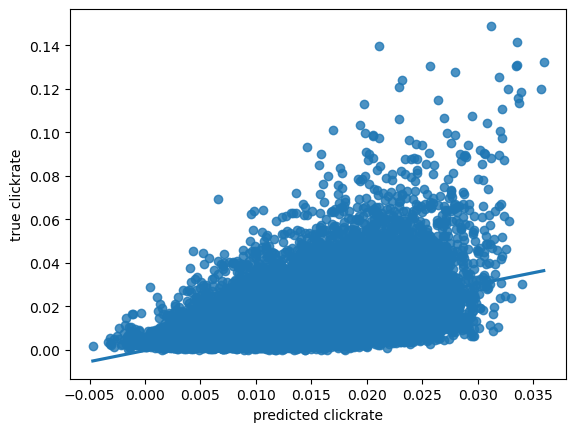

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
# print stuff. 
predictions = ridge_model.predict(stored_embeddings)
print(predictions.max())
# visualize real and predicted values
fig, ax = plt.subplots()
sns.regplot(x = predictions, y = df.clickrate, ax=ax)
ax.set(ylabel = 'true clickrate', xlabel = 'predicted clickrate')

## 2.Causal Model 

Implement Causal Model: + Reading
    - We divide every click rate by the article mean and the plug it in regression

In [12]:
#calculating mean per clickability_test_id and eyecatcher_id
df["means"] = df.groupby(["clickability_test_id","eyecatcher_id"])["clickrate"].transform("mean")
df.columns
df["adjusted_clickrate"] = df["clickrate"]/df["means"]
# set rows with 0 clicks -> adjusted clickrates NA - set to zero
df["adjusted_clickrate"] = df["adjusted_clickrate"].fillna(0)
print(df["adjusted_clickrate"].isna().sum())
adjusted_clickrate = torch.tensor(df.adjusted_clickrate.values)

0


In [13]:
# What do we do with headlines that did not get any clicks? 
# Will they just have an adjusted clickrate of zero?
df.loc[(df["clickrate"]/df["means"]).isna(), ['headline', 'eyecatcher_id', 'clicks', 'impressions', 'means', 'clickrate']]

,headline,eyecatcher_id,clicks,impressions,means,clickrate


## 2.1 Causal model with Ridge Regression 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, adjusted_clickrate, test_size=0.2)
causal_ridge_model =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
causal_ridge_model.fit(X_train, y_train)
causal_ridge_model.score(X_train,y_train)
causal_predictions_rg = causal_ridge_model.predict(X_test)
rmse = mean_squared_error(y_test, causal_predictions_rg)
print("Causal Ridge Regression MSE for click difference:", rmse)
print("Causal Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=causal_predictions_rg))
df["causal_predictions_ridge"] = causal_ridge_model.predict(stored_embeddings)

Causal Ridge Regression MSE for click difference: 0.08645792502060719
Causal Ridge Regression R2 for click difference: 0.06109629223821089


## 2.2 Causal model with Linear Regression

Causal Linear Regression MSE for clicks: 0.2962514513952676
Causal Linear Regression R2 for clicks: 0.046902743922428214


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='causal_predictions_linear', ylabel='Count'>

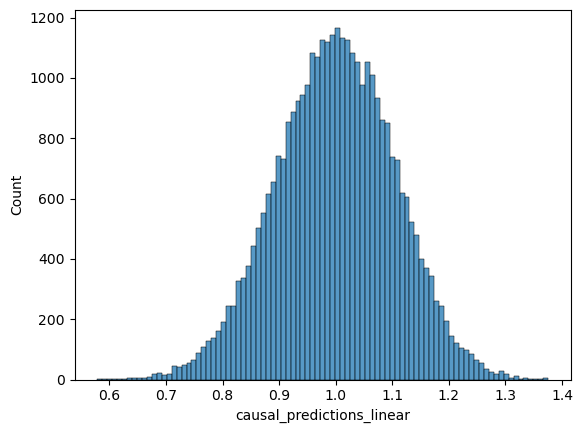

In [15]:
causal_linear_model =LinearRegression()
causal_linear_model.fit(X_train, y_train)
causal_linear_model.score(X_train,y_train)
causal_predictions_lm = causal_linear_model.predict(X_test)
rmse = mean_squared_error(y_test, causal_predictions_lm, squared=False)
print("Causal Linear Regression MSE for clicks:", rmse)
print("Causal Linear Regression R2 for clicks:", r2_score(y_true=y_test, y_pred=causal_predictions_lm))
df["causal_predictions_linear"] = causal_linear_model.predict(stored_embeddings)
sns.histplot(df["causal_predictions_linear"])

## 3.1 Compare top / bottom 20 causal model with correlational model - Ridge Regression


In [16]:
from ipywidgets import widgets, Layout
from IPython import display


last20_pred = df.sort_values(["predictions_ridge"],ascending=True).loc[:,['headline']][:20]
last20_pred_causal = df.sort_values(["causal_predictions_ridge"],ascending=True).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Ridge'))
    last20_pred.info()
with widget2:
    display.display(last20_pred_causal.style.set_caption('Last 20 Causal'))
    last20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [17]:
#Checking for intersection
np.intersect1d(last20_pred.values,last20_pred_causal.values)

array(["Can We Make Space To Hear People's Stories, Or Are Corporations The Only Ones With A Voice?",
       'Solidarity Is For Everyone But Those Who Really Need It'],
      dtype=object)

In [18]:
first20_pred = df.sort_values(["predictions_ridge"],ascending=False).loc[:,['headline']][:20]
first20_pred_causal = df.sort_values(["causal_predictions_ridge"],ascending=False).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(first20_pred.style.set_caption('First 20 Ridge'))
    first20_pred.info()
with widget2:
    display.display(first20_pred_causal.style.set_caption('First 20 Causal'))
    first20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [19]:
np.intersect1d(first20_pred.values,first20_pred_causal.values)

array([], dtype=object)

In [20]:
df["predictions_linear"]

82808    0.004132
82811    0.013682
82818    0.018055
82817    0.007344
63717    0.016018
           ...   
27235    0.012555
27228    0.018815
68403    0.013602
9177     0.003766
9179     0.004125
Name: predictions_linear, Length: 34642, dtype: float32

## 3.1 Compare top / bottom 20 causal model with correlational model - Linear

In [21]:
last20_pred = df.sort_values(["predictions_linear"],ascending=True).loc[:,['headline']][:20]
last20_pred_causal = df.sort_values(["causal_predictions_linear"],ascending=True).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Linear'))
    last20_pred.info()
with widget2:
    display.display(last20_pred_causal.style.set_caption('Last 20 Causal'))
    last20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [22]:
#Checking for intersection
np.intersect1d(last20_pred.values,last20_pred_causal.values)

array(["Can We Make Space To Hear People's Stories, Or Are Corporations The Only Ones With A Voice?"],
      dtype=object)

In [23]:
first20_pred = df.sort_values(["predictions_linear"],ascending=False).loc[:,['headline']][:20]
first20_pred_causal = df.sort_values(["causal_predictions_linear"],ascending=False).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(first20_pred.style.set_caption('First 20 Linear'))
    first20_pred.info()
with widget2:
    display.display(first20_pred_causal.style.set_caption('First 20 Causal'))
    first20_pred_causal.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [24]:
#Checking for intersection
np.intersect1d(first20_pred.values,first20_pred_causal.values)

array([], dtype=object)

## 4.1 Shapley Values Ridge Regression predicting Clickrate

In [25]:
# load the model

# here we also need embeddings - the whole thing is our model
model = SentenceTransformer(
    "sentence-transformers/all-mpnet-base-v2")

# this defines an explicit python function that takes a list of strings and outputs scores for each class
def f(x):
    embedding = model.encode(x)
    return ridge_model.predict(embedding)

In [26]:
#defining masker - the masker specifies how to hide portions of the input
method = "default masker" #before it was custo tokenizer, but it works the same with the default one so i would say remove everything and just leave the defining of the whitespace masker

# build an explainer by passing a transformers tokenizer
if method == "transformers tokenizer":
    explainer = shap.Explainer(f)

# build an explainer by explicitly creating a masker
elif method == "default masker":
    masker  = shap.maskers.Text("\W|'")   # this will create a basic whitespace tokenizer.
    #A whitespace tokenizer breaks a text into tokens based on whitespace characters (spaces, tabs, newlines,/, etc.)
    explainer = shap.Explainer(f, masker)



### 4.1.1 Checking Shap values for top 20 predictions made with ridge

In [27]:
top_values = df.sort_values(["predictions_ridge"],ascending=False).loc[:,['headline']][:20]
#removing duplicates, so they dont influence the overall 
top_values = top_values.drop_duplicates(keep='first')
top_shap_values_ridge = explainer(top_values["headline"])


  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|███                                                          | 1/20 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|███████▉                                             | 3/20 [00:57<03:36, 12.76s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██████████▌                                          | 4/20 [01:18<04:17, 16.07s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|█████████████▎                                       | 5/20 [01:28<03:27, 13.86s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███████████████▉                                     | 6/20 [01:48<03:45, 16.08s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|██████████████████▌                                  | 7/20 [02:07<03:39, 16.86s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|█████████████████████▏                               | 8/20 [02:34<04:01, 20.16s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|███████████████████████▊                             | 9/20 [02:44<03:08, 17.11s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|██████████████████████████                          | 10/20 [03:02<02:53, 17.36s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|████████████████████████████▌                       | 11/20 [03:11<02:14, 14.89s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|███████████████████████████████▏                    | 12/20 [03:38<02:27, 18.47s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|█████████████████████████████████▊                  | 13/20 [03:48<01:51, 15.99s/it]

  0%|          | 0/156 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|████████████████████████████████████▍               | 14/20 [03:57<01:21, 13.64s/it]

  0%|          | 0/156 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████████████████████████████████████             | 15/20 [04:05<01:00, 12.13s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████████████████████████████████████████▏       | 17/20 [04:35<00:37, 12.59s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|██████████████████████████████████████████████▊     | 18/20 [05:04<00:34, 17.47s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████████████████████████████████████████████▍  | 19/20 [05:22<00:17, 17.45s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████| 20/20 [05:31<00:00, 15.01s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer: 21it [05:49, 17.49s/it]                                                                  


In [28]:
#predictions = ridge_model.predict(stored_embeddings[0].reshape(1,-1)) # i am not sure what is that and if we need it ??

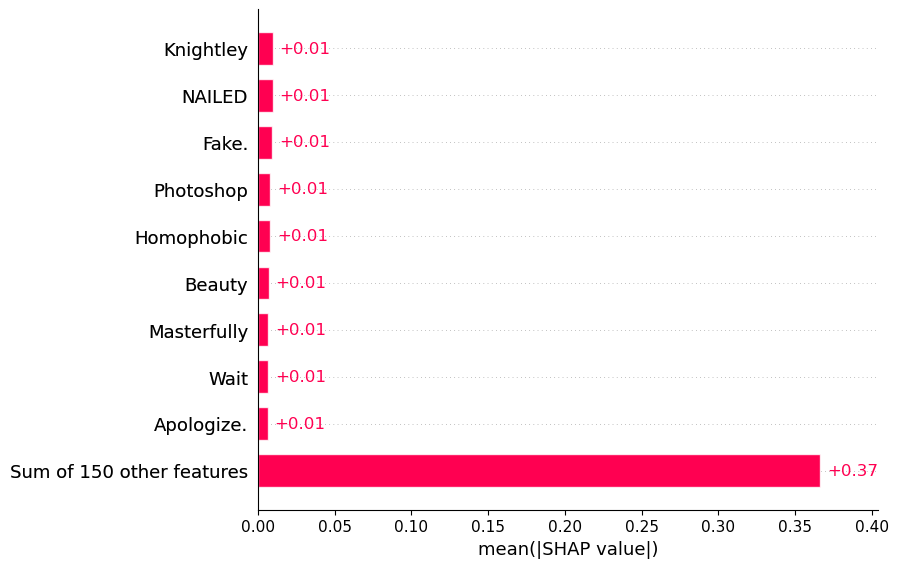

In [29]:
for i in range(5): #just checking for 5 of them for example
    shap.plots.text(top_shap_values_ridge[i])
shap.plots.bar(top_shap_values_ridge)

### 4.1.2 Checking for least 20 if there are words that had negative impact, because they will be the ones that will make the click rate lower

In [30]:
lowest_values = df.sort_values(["predictions_ridge"],ascending=True).loc[:,['headline']][:20]
lowest_values["headline"]
lowest_values = lowest_values.drop_duplicates(keep='first')
lowest_shap_values_ridge = explainer(lowest_values["headline"])


  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|███                                                          | 1/20 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|███████▉                                             | 3/20 [00:35<01:11,  4.20s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██████████▌                                          | 4/20 [01:00<03:27, 12.95s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|█████████████▎                                       | 5/20 [01:21<03:58, 15.92s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███████████████▉                                     | 6/20 [01:36<03:40, 15.74s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|██████████████████▌                                  | 7/20 [02:08<04:33, 21.01s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|███████████████████████▊                             | 9/20 [02:17<02:13, 12.13s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|████████████████████████████▌                       | 11/20 [02:29<01:17,  8.65s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|███████████████████████████████▏                    | 12/20 [02:55<01:52, 14.06s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|█████████████████████████████████▊                  | 13/20 [03:23<02:06, 18.11s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|████████████████████████████████████▍               | 14/20 [03:41<01:49, 18.28s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████████████████████████████████████             | 15/20 [03:54<01:23, 16.66s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|█████████████████████████████████████████▌          | 16/20 [04:16<01:13, 18.28s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████████████████████████████████████████▏       | 17/20 [04:31<00:52, 17.34s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|██████████████████████████████████████████████▊     | 18/20 [04:44<00:31, 15.94s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████████████████████████████████████████████▍  | 19/20 [05:23<00:22, 22.73s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████| 20/20 [05:43<00:00, 21.99s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

PartitionExplainer explainer: 21it [05:50, 17.54s/it]                                                                  


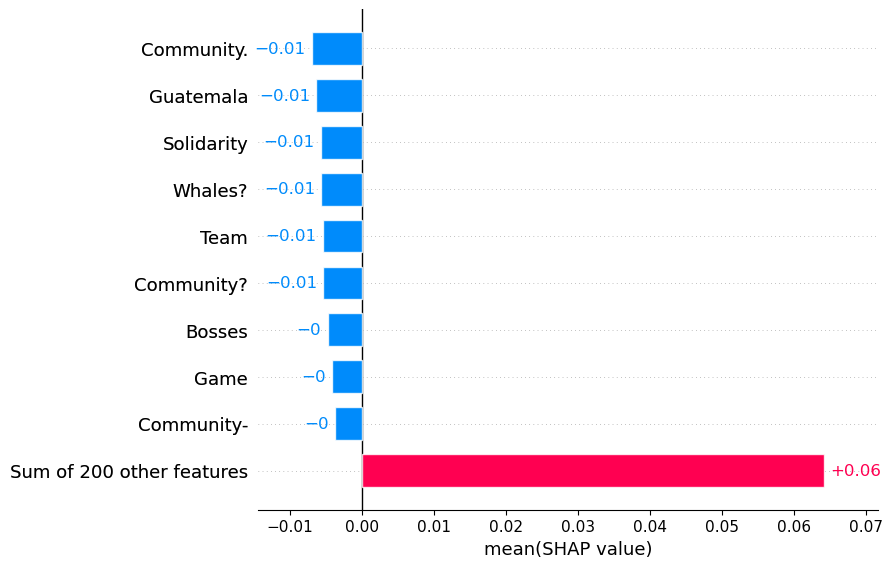

In [31]:
for i in range(5):
    shap.plots.text(lowest_shap_values_ridge[i])
shap.plots.bar(lowest_shap_values_ridge.mean(0),order=shap.Explanation.argsort)

## 4.2 Shapley Values Linear Regression predicting Clickrate

In [32]:
# load the model

# here we also need embeddings - the whole thing is our model
model = SentenceTransformer(
    "sentence-transformers/all-mpnet-base-v2")

# this defines an explicit python function that takes a list of strings and outputs scores for each class
def f(x):
    embedding = model.encode(x)
    return linear_model.predict(embedding)

In [33]:
#defining masker - the masker specifies how to hide portions of the input
method = "default masker" #before it was custo tokenizer, but it works the same with the default one so i would say remove everything and just leave the defining of the whitespace masker

# build an explainer by passing a transformers tokenizer
if method == "transformers tokenizer":
    explainer = shap.Explainer(f)

# build an explainer by explicitly creating a masker
elif method == "default masker":
    masker  = shap.maskers.Text("\W|'")   # this will create a basic whitespace tokenizer.
    #A whitespace tokenizer breaks a text into tokens based on whitespace characters (spaces, tabs, newlines,/, etc.)
    explainer = shap.Explainer(f, masker)


### 4.2.1 Checking for shap values for top 20 predictions made with linear regression

In [34]:
top_values = df.sort_values(["predictions_linear"],ascending=False).loc[:,['headline']][:20]
#removing duplicates, so they dont influence the overall 
top_values = top_values.drop_duplicates(keep='first')
top_shap_values_linear = explainer(top_values["headline"])

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|███                                                          | 1/20 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|███████▉                                             | 3/20 [00:50<03:44, 13.18s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██████████▌                                          | 4/20 [01:12<04:29, 16.84s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|█████████████▎                                       | 5/20 [01:41<05:17, 21.20s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███████████████▉                                     | 6/20 [02:00<04:44, 20.34s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|██████████████████▌                                  | 7/20 [02:19<04:19, 19.94s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|█████████████████████▏                               | 8/20 [02:30<03:23, 16.99s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|███████████████████████▊                             | 9/20 [02:41<02:46, 15.15s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|██████████████████████████                          | 10/20 [03:14<03:26, 20.63s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|████████████████████████████▌                       | 11/20 [03:35<03:09, 21.00s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|███████████████████████████████▏                    | 12/20 [03:46<02:23, 17.95s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|█████████████████████████████████▊                  | 13/20 [03:56<01:48, 15.47s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|████████████████████████████████████▍               | 14/20 [04:06<01:21, 13.62s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████████████████████████████████████             | 15/20 [04:35<01:32, 18.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|█████████████████████████████████████████▌          | 16/20 [05:14<01:38, 24.65s/it]

  0%|          | 0/110 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████████████████████████████████████████▏       | 17/20 [05:20<00:56, 18.92s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|██████████████████████████████████████████████▊     | 18/20 [05:48<00:43, 21.84s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████████████████████████████████████████████▍  | 19/20 [06:01<00:18, 18.93s/it]

  0%|          | 0/156 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████| 20/20 [06:09<00:00, 15.77s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 21it [06:21, 19.08s/it]                                                                  


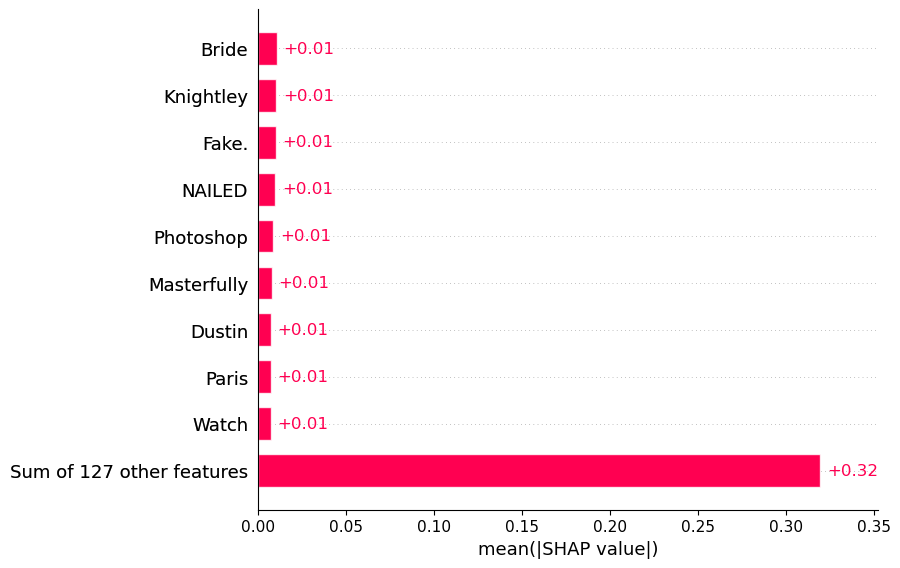

In [35]:
for i in range(5):
    shap.plots.text(top_shap_values_linear[i])
shap.plots.bar(top_shap_values_linear)

### 4.1.2 Checking for least 20 if there are words that had negative impact, because they will be the ones that will make the click rate lower

In [36]:
lowest_values = df.sort_values(["predictions_linear"],ascending=True).loc[:,['headline']][:20]
lowest_values = lowest_values.drop_duplicates(keep='first')
lowest_shap_values_linear = explainer(lowest_values["headline"])

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|███                                                          | 1/20 [00:00<?, ?it/s]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|███████▉                                             | 3/20 [00:49<02:58, 10.50s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██████████▌                                          | 4/20 [00:56<02:25,  9.07s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|█████████████▎                                       | 5/20 [01:13<02:58, 11.91s/it]

  0%|          | 0/156 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███████████████▉                                     | 6/20 [01:22<02:30, 10.77s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|██████████████████▌                                  | 7/20 [01:29<02:05,  9.67s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|███████████████████████▊                             | 9/20 [01:49<01:41,  9.27s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|██████████████████████████                          | 10/20 [02:01<01:42, 10.26s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|████████████████████████████▌                       | 11/20 [02:28<02:16, 15.17s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|███████████████████████████████▏                    | 12/20 [02:46<02:08, 16.03s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|████████████████████████████████████▍               | 14/20 [03:17<01:27, 14.66s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████████████████████████████████████             | 15/20 [03:48<01:38, 19.72s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|█████████████████████████████████████████▌          | 16/20 [04:04<01:13, 18.43s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████████████████████████████████████████▏       | 17/20 [04:11<00:45, 15.14s/it]

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|██████████████████████████████████████████████▊     | 18/20 [04:31<00:33, 16.65s/it]

  0%|          | 0/110 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████████████████████████████████████████████▍  | 19/20 [04:37<00:13, 13.38s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████| 20/20 [04:45<00:00, 11.55s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 21it [04:57, 14.89s/it]                                                                  


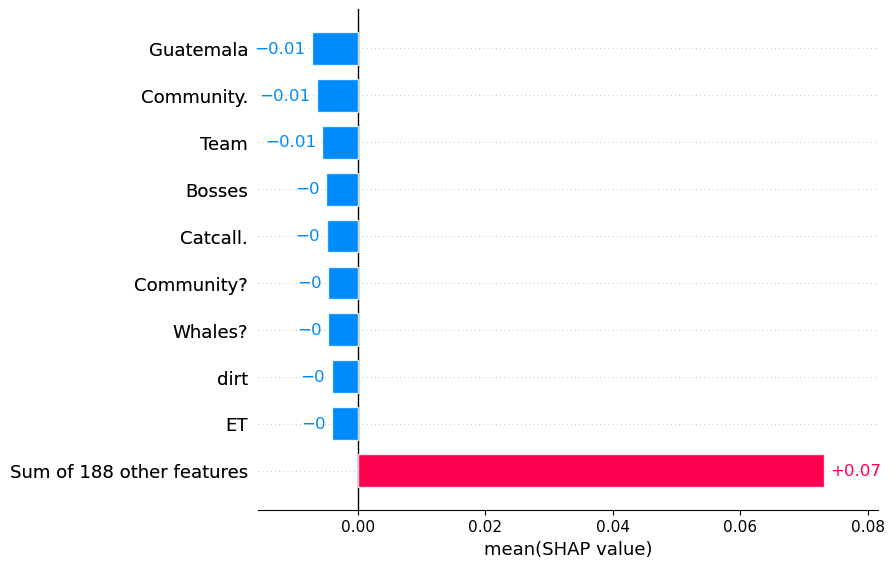

In [37]:
for i in range(5):
    shap.plots.text(lowest_shap_values_linear[i])
shap.plots.bar(lowest_shap_values_linear.mean(0),order=shap.Explanation.argsort)